# Import

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
filepath="/content/drive/MyDrive/Colab Notebooks"

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
import random
import os

# Cố định seed cho Python, NumPy, TensorFlow
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Cố định chế độ chạy đơn luồng (tránh nhiễu từ CPU)
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Đọc file

In [ ]:
df1 = pd.read_csv(f"{filepath}/Stock_VCB_filled.csv")
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371 entries, 0 to 1370
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1371 non-null   object 
 1   code          1371 non-null   object 
 2   high          1371 non-null   float64
 3   low           1371 non-null   float64
 4   open          1371 non-null   float64
 5   close         1371 non-null   float64
 6   volume_match  1371 non-null   int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 75.1+ KB


In [ ]:
# Convert 'date' column to pandas datetime format
df1['date'] = pd.to_datetime(df1['date'])  # Convert to datetime
df1.set_index('date', inplace=True)  # Set as index, so that pandas can handle timeseries
df1 = df1.sort_index()  # Ensure it's sorted

In [ ]:
df1

,code,high,low,open,close,volume_match
date,,,,,,
2019-10-01,VCB,83.6,81.8,82.1,83.4,795100
2019-10-02,VCB,83.7,81.7,83.4,82.0,1224650
2019-10-03,VCB,82.0,80.6,81.8,82.0,1003810
2019-10-04,VCB,83.5,81.8,82.0,83.0,1121700
2019-10-07,VCB,84.5,82.8,82.0,82.8,1134390
...,...,...,...,...,...,...
2024-12-25,VCB,93.8,92.2,92.2,92.4,1827700
2024-12-26,VCB,92.8,92.0,92.5,92.1,2202900
2024-12-27,VCB,93.0,92.2,92.5,92.2,1639900


In [ ]:
df2 = pd.read_csv(f"{filepath}/Stock_VNindex_filled.csv")
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371 entries, 0 to 1370
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1371 non-null   object 
 1   code          1371 non-null   object 
 2   high          1371 non-null   float64
 3   low           1371 non-null   float64
 4   open          1371 non-null   float64
 5   close         1371 non-null   float64
 6   adjust        1371 non-null   float64
 7   volume_match  1371 non-null   float64
 8   value_match   1371 non-null   float64
dtypes: float64(7), object(2)
memory usage: 96.5+ KB


In [ ]:
# Convert 'date' column to pandas datetime format
df2['date'] = pd.to_datetime(df2['date'])  # Convert to datetime
df2.set_index('date', inplace=True)  # Set as index, so that pandas can handle timeseries
df2 = df2.sort_index()  # Ensure it's sorted

In [ ]:
df2

,code,high,low,open,close,adjust,volume_match,value_match
date,,,,,,,,
2019-10-01,VNINDEX,999.72,996.20,997.87,999.59,999.59,138885870.0,3.113323e+12
2019-10-02,VNINDEX,1000.93,989.63,999.18,991.19,991.19,152337130.0,3.552889e+12
2019-10-03,VNINDEX,992.45,983.35,985.65,992.45,992.45,153492420.0,3.243848e+12
2019-10-04,VNINDEX,994.81,987.59,993.69,987.59,987.59,150673460.0,3.264212e+12
2019-10-07,VNINDEX,990.34,983.09,989.45,983.09,983.09,147636100.0,3.089197e+12
...,...,...,...,...,...,...,...,...
2024-12-25,VNINDEX,1283.09,1261.87,1262.03,1274.04,1274.04,724345690.0,1.651200e+13
2024-12-26,VNINDEX,1277.17,1271.99,1275.68,1272.87,1272.87,502071890.0,1.064038e+13
2024-12-27,VNINDEX,1277.89,1272.23,1275.56,1275.14,1275.14,579882989.0,1.328606e+13


In [ ]:
# Tính EMA 12 ngày và EMA 26 ngày
df2['ema_12'] = df2['close'].ewm(span=12, adjust=False).mean()
df2['ema_26'] = df2['close'].ewm(span=26, adjust=False).mean()

# Tính MACD
df2['macd'] = df2['ema_12'] - df2['ema_26']

# Tính Signal Line (EMA 9 ngày của MACD)
df2['macd_signal'] = df2['macd'].ewm(span=9, adjust=False).mean()

# Hiển thị kết quả
print(df2[['close', 'macd', 'macd_signal']].head())

             close      macd  macd_signal
date                                     
2019-10-01  999.59  0.000000     0.000000
2019-10-02  991.19 -0.670085    -0.134017
2019-10-03  992.45 -1.086932    -0.324600
2019-10-04  987.59 -1.788827    -0.617445
2019-10-07  983.09 -2.677333    -1.029423


In [ ]:
df2

,code,high,low,open,close,adjust,volume_match,value_match,ema_12,ema_26,macd,macd_signal
date,,,,,,,,,,,,
2019-10-01,VNINDEX,999.72,996.20,997.87,999.59,999.59,138885870.0,3.113323e+12,999.590000,999.590000,0.000000,0.000000
2019-10-02,VNINDEX,1000.93,989.63,999.18,991.19,991.19,152337130.0,3.552889e+12,998.297692,998.967778,-0.670085,-0.134017
2019-10-03,VNINDEX,992.45,983.35,985.65,992.45,992.45,153492420.0,3.243848e+12,997.398047,998.484979,-1.086932,-0.324600
2019-10-04,VNINDEX,994.81,987.59,993.69,987.59,987.59,150673460.0,3.264212e+12,995.889117,997.677944,-1.788827,-0.617445
2019-10-07,VNINDEX,990.34,983.09,989.45,983.09,983.09,147636100.0,3.089197e+12,993.920022,996.597355,-2.677333,-1.029423
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-25,VNINDEX,1283.09,1261.87,1262.03,1274.04,1274.04,724345690.0,1.651200e+13,1262.507215,1258.347473,4.159742,3.725967
2024-12-26,VNINDEX,1277.17,1271.99,1275.68,1272.87,1272.87,502071890.0,1.064038e+13,1264.101490,1259.423215,4.678274,3.916428
2024-12-27,VNINDEX,1277.89,1272.23,1275.56,1275.14,1275.14,579882989.0,1.328606e+13,1265.799722,1260.587422,5.212300,4.175603


In [ ]:
df3 = pd.read_csv(f"{filepath}/bullish_index_summary.csv")
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371 entries, 0 to 1370
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                1371 non-null   object 
 1   total_articles      1371 non-null   int64  
 2   bullish_index       1371 non-null   float64
 3   dominant_sentiment  1371 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 43.0+ KB


In [ ]:
# Convert 'date' column to pandas datetime format
df3['date'] = pd.to_datetime(df3['date'])  # Convert to datetime
df3.set_index('date', inplace=True)  # Set as index, so that pandas can handle timeseries
df3 = df3.sort_index()  # Ensure it's sorted

In [ ]:
df3

,total_articles,bullish_index,dominant_sentiment
date,,,
2019-10-01,12,0.625000,neutral
2019-10-02,13,0.769231,positive
2019-10-03,12,0.625000,positive
2019-10-04,22,0.659091,positive
2019-10-07,17,0.441176,negative
...,...,...,...
2024-12-25,44,0.625000,neutral
2024-12-26,43,0.639535,positive
2024-12-27,56,0.580357,positive


In [ ]:
# Mã hóa sentiment thành các giá trị số
df3['sentiment_encoded'] = df3['dominant_sentiment'].map({'positive': 1, 'negative': -1, 'neutral': 0})

# Kiểm tra kết quả
# Use df3.index to access the date which is now the index
print(df3[['dominant_sentiment', 'sentiment_encoded']].head())
print(df3.index[:5]) # Print the first 5 dates from the index

           dominant_sentiment  sentiment_encoded
date                                            
2019-10-01            neutral                  0
2019-10-02           positive                  1
2019-10-03           positive                  1
2019-10-04           positive                  1
2019-10-07           negative                 -1
DatetimeIndex(['2019-10-01', '2019-10-02', '2019-10-03', '2019-10-04',
               '2019-10-07'],
              dtype='datetime64[ns]', name='date', freq=None)


In [ ]:
# Merge dữ liệu
df = df1.merge(df2[['macd', 'macd_signal']], on='date', how='left', suffixes=('', '_vnindex'))
# df = df.merge(df3[['bullish_index', 'sentiment_encoded']], on='date', how='left')

# Loại bỏ các hàng có giá trị NaN
df.dropna(inplace=True)

In [ ]:
df.drop(columns=['code'], inplace=True)

# Xử lý

In [ ]:
# Tạo scaler cho toàn bộ dữ liệu nhưng giữ scaler riêng cho 'close'
scaler = MinMaxScaler()
scaler_close = MinMaxScaler()

columns_to_scale = ['high', 'low', 'open', 'volume_match', 'macd', 'macd_signal']

# Chia dữ liệu train/test TRƯỚC khi scale
train_size = int(len(df) * 0.8)
df_train = df.iloc[:train_size]
df_test = df.iloc[train_size:]

# Fit trên train, transform trên test
df_train[columns_to_scale] = scaler.fit_transform(df_train[columns_to_scale])
df_test[columns_to_scale] = scaler.transform(df_test[columns_to_scale])

# Scale riêng cột 'close'
df_train[['close']] = scaler_close.fit_transform(df_train[['close']])
df_test[['close']] = scaler_close.transform(df_test[['close']])

# Ghép lại thành df_scaled (không ảnh hưởng tới quá trình train-test)
df_scaled = pd.concat([df_train, df_test])

# Hàm tạo chuỗi dữ liệu
def create_sequences(data, target_column, time_steps=30):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data.iloc[i:i+time_steps].values)
        y.append(data.iloc[i+time_steps][target_column])
    return np.array(X), np.array(y)

time_steps = 30
target_column = 'close'  # Dự đoán giá đóng cửa VCB

X, y = create_sequences(df_scaled, target_column, time_steps)

# Chia train-test từ X, y
X_train, X_test, y_train, y_test = X[:train_size - time_steps], X[train_size - time_steps:], y[:train_size - time_steps], y[train_size - time_steps:]

<ipython-input-18-fb053c7deb47>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[columns_to_scale] = scaler.fit_transform(df_train[columns_to_scale])
<ipython-input-18-fb053c7deb47>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[columns_to_scale] = scaler.transform(df_test[columns_to_scale])
<ipython-input-18-fb053c7deb47>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

In [ ]:
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True, input_shape=(time_steps, X.shape[2]))),
    Dropout(0.2),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - loss: 0.0686 - val_loss: 0.0013
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - loss: 0.0084 - val_loss: 0.0011
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.0056 - val_loss: 0.0014
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0054 - val_loss: 8.2566e-04
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 0.0047 - val_loss: 9.3377e-04
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 200ms/step - loss: 0.0044 - val_loss: 8.5544e-04
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0038 - val_loss: 6.2907e-04
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.0037 - val_loss: 6.8952e-04
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0039 - val_loss: 6.1782e-04
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 0.0036 - val_loss: 0.0018
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 0.0039 - val_loss: 9.5594e-04
Epoch 12/100
34/34 ━━

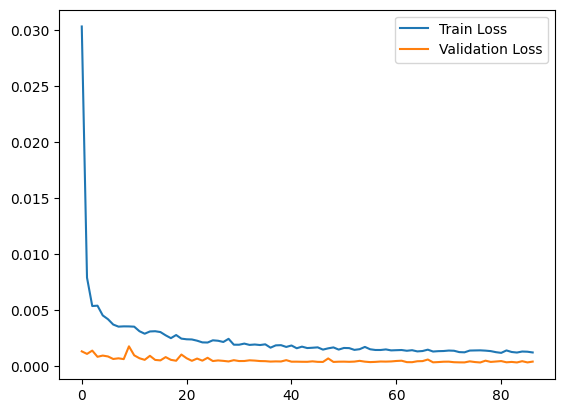

In [ ]:
# Vẽ biểu đồ loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step


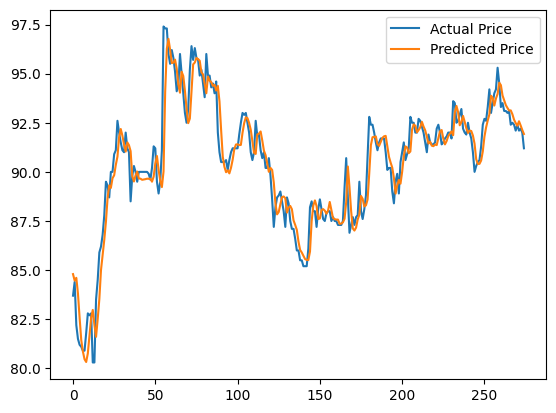

In [ ]:

y_pred = model.predict(X_test)

# Inverse transform chỉ cột "close"
y_pred_rescaled = scaler_close.inverse_transform(y_pred.reshape(-1, 1))[:, 0]
y_test_rescaled = scaler_close.inverse_transform(y_test.reshape(-1, 1))[:, 0]

# Vẽ biểu đồ dự đoán
plt.plot(y_test_rescaled, label='Actual Price')
plt.plot(y_pred_rescaled, label='Predicted Price')
plt.legend()
plt.show()

In [ ]:
"""# Dự đoán giá tương lai"""

def predict_next_days(model, last_data, scaler_close, days=10):
    predictions = []
    input_data = last_data.copy()

    for _ in range(days):
        pred = model.predict(input_data.reshape(1, time_steps, -1))[0, 0]
        predictions.append(pred)

        # Dịch input_data lên và thay thế giá dự đoán
        input_data = np.roll(input_data, -1, axis=0)
        input_data[-1, -1] = pred  # Chỉ cập nhật cột close

    # Inverse transform chỉ cho cột close
    predictions = np.array(predictions).reshape(-1, 1)
    predicted_prices = scaler_close.inverse_transform(predictions)[:, 0]

    return predicted_prices
# Dự đoán 10 ngày tới
future_prices = predict_next_days(model, X_test[-1], scaler_close, days=10)
print(future_prices)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
[91.92868  91.113976 90.704704 90.51539  90.512276 90.854836 91.46597
 91.75956  92.00257  92.25988 ]


In [ ]:
import numpy as np

# Dự đoán giá tương lai
def predict_next_days(model, last_data, scaler_close, days=15):
    predictions = []
    input_data = last_data.copy()

    for _ in range(days):
        pred = model.predict(input_data.reshape(1, time_steps, -1))[0, 0]
        predictions.append(pred)

        # Dịch input_data lên và thay thế giá dự đoán
        input_data = np.roll(input_data, -1, axis=0)
        input_data[-1, -1] = pred  # Chỉ cập nhật cột close

    # Inverse transform chỉ cho cột close
    predictions = np.array(predictions).reshape(-1, 1)
    predicted_prices = scaler_close.inverse_transform(predictions)[:, 0]

    return predicted_prices

# Dự đoán 10 ngày tới
future_prices = predict_next_days(model, X_test[-1], scaler_close, days=15)

# Tạo danh sách ngày dự đoán (giả sử bắt đầu từ ngày tiếp theo)
import pandas as pd
from datetime import datetime, timedelta

start_date = datetime.strptime("2025-01-01", "%Y-%m-%d")  # Thay bằng ngày thực tế
future_dates = [start_date + timedelta(days=i) for i in range(len(future_prices))]

# In kết quả theo chiều dọc
print("Dự đoán giá VCB cho 15 ngày tiếp theo:\n")
for i, (date, price) in enumerate(zip(future_dates, future_prices)):
    print(f"{i:<2} {date.strftime('%Y-%m-%d')}  {price:.6f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Dự đoán giá VCB cho 15 ngày tiếp theo:

0  2025-01-01  91.928680
1  2025-01-02  91.113976
2  2025-01-03  90.704704
3  2025-01-04  90.515388
4  2025-01-05  90.512276
5  2025-01-06  90.854836
6  2025-01-07  91.465973
7  2025-01-08  91.759560
8  2025-01-09  92.002571
9  2025-01-10  92.259880
10 2025-01-11  93.169060
11 2025-01-12  92.978722
12 2025-01-13  92.601250
13 2025-01-14  93.163132
14 2025-01-15  93.495903


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
# Tính MAPE
mape = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)
# Tính MAE
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)

# Tính MSE
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)

# Tính RMSE (Căn bậc hai của MSE)
rmse = np.sqrt(mse)

# In kết quả đánh giá
print(f"📊 Đánh giá mô hình BiLSTM:")
print(f"MAE  (Mean Absolute Error): {mae:.4f}")
print(f"MSE  (Mean Squared Error) : {mse:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")


📊 Đánh giá mô hình BiLSTM:
MAE  (Mean Absolute Error): 0.7371
MSE  (Mean Squared Error) : 1.1146
RMSE (Root Mean Squared Error): 1.0557
MAPE (Mean Absolute Percentage Error): 0.82%
